In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In this dataset the target variable is y variable - has the client subscribed a term deposit or not.

In [4]:
df = df.drop(['default', 'loan'], axis=1)
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.y = (df.y == 'yes').astype(int)

In [7]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int32
dtype: object

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that.  

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [9]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
for n in numerical:
    model = LogisticRegression()
    model.fit(df_train[[n]], y_train)
    
    y_pred_proba = model.predict_proba(df_train[[n]])[:, 1]
    
    auc_score = roc_auc_score(y_train, y_pred_proba)
    
    print(f'Feature: {n}, ROC AUC score: {auc_score}')

Feature: age, ROC AUC score: 0.48781428247265596
Feature: balance, ROC AUC score: 0.5888313805382317
Feature: day, ROC AUC score: 0.525957882383908
Feature: duration, ROC AUC score: 0.8147002759670778
Feature: campaign, ROC AUC score: 0.5714543015682159
Feature: pdays, ROC AUC score: 0.5901276247352144
Feature: previous, ROC AUC score: 0.5985653242764153


**Which numerical variable has the highest AUC?**  
**Answer: duration**

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [12]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

auc_score = roc_auc_score(y_val, y_pred)

print(f'ROC AUC score: {auc_score}')


ROC AUC score: 0.9003324959598795


**What's the AUC of this model on the validation dataset?**  
**Answer: 0.90**

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01  
For each threshold, compute precision and recall  
Plot them  

At which threshold precision and recall curves intersect?

In [13]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp) 
    r = tp / (tp + fn) 
    
    scores.append((t, p, r))

    

C:\Users\emmah\AppData\Local\Temp\ipykernel_15452\4294824332.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


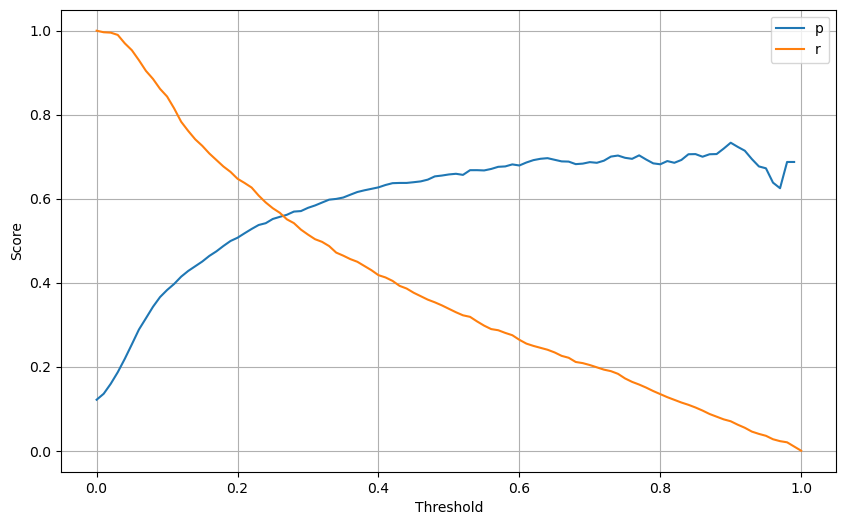

In [14]:
columns = ['t', 'p', 'r'] 
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.plot(x='t', y=['p', 'r'], kind='line', figsize=(10, 6))
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.show()

**At which threshold do the precision and recall curves intersect?**  
**Answer: 0.265**

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 ⋅ (P ⋅ R) / (P + R)

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal? 

In [15]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp) 
    r = tp / (tp + fn) 
    
    f1 = (2 * p * r) / (p + r)
    
    scores.append((t, f1))

C:\Users\emmah\AppData\Local\Temp\ipykernel_15452\2700995159.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


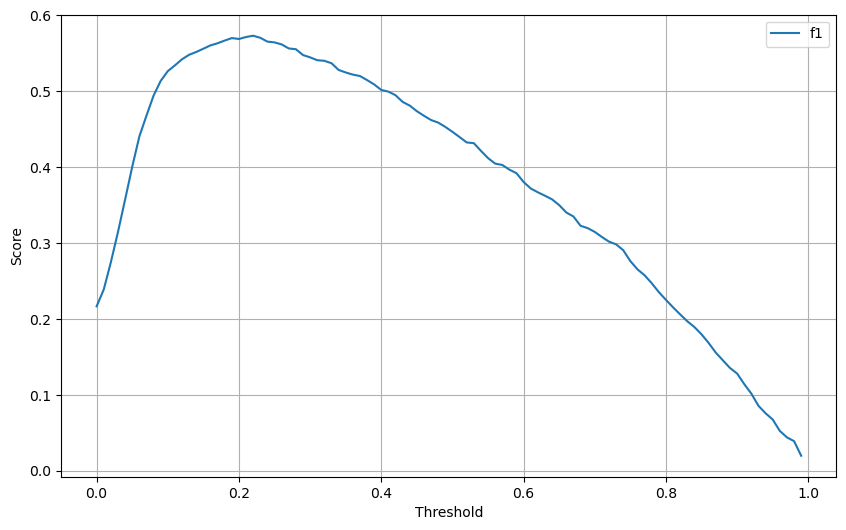

In [16]:
columns = ['t', 'f1'] 
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.plot(x='t', y=['f1'], kind='line', figsize=(10, 6))
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.show()

**At which threshold F1 is maximal?**  
**Answer: 0.22**

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)  
Iterate over different folds of df_full_train  
Split the data into train and validation  
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)  
Use AUC to evaluate the model on validation  
How large is standard deviation of the scores across different folds?

In [18]:
from sklearn.model_selection import KFold

In [37]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [39]:
dv, model = train(df_train, y_train)

In [40]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [41]:
y_pred = predict(df_val, dv, model)

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.005


**How large is standard deviation of the scores across different folds?**  
**Answer: 0.005**

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C  

Iterate over the following C values: [0.000001, 0.001, 1]  
Initialize KFold with the same parameters as previously  
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)  
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)  

Which C leads to the best mean score?

In [43]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
 
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [44]:
C_values = [0.000001, 0.001, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [45]:
for C in C_values:
    print(f'Evaluating model with C={C}')
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C)
        
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    print('C=%.6f -> AUC: %.3f +- %.3f' % (C, round(mean_auc, 3), round(std_auc, 3)))

Evaluating model with C=1e-06
C=0.000001 -> AUC: 0.701 +- 0.009
Evaluating model with C=0.001
C=0.001000 -> AUC: 0.861 +- 0.007
Evaluating model with C=1
C=1.000000 -> AUC: 0.906 +- 0.005


**Which C leads to the best mean score?**  
**Answer: C=1.0**